### Import Cells

In [124]:
#Generic import Cell
import torch
from torch.autograd import Variable
import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from time import time
import re
import json
import astropy
from astropy.stats import histogram
from scipy import stats
import astropy.units as u
import astropy.constants as constant
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.units import dimensionless
import pandas as pd
import tqdm as tqdm
from tqdm import tqdm
import importlib
print(f'Pytorch version {torch.__version__}')

Pytorch version 2.0.1


In [125]:
sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems

### Set Parameters

In [191]:
potential_type = 'plummer' #used to select potential {'plummer','?'}
unit_type = 'dimensionless' #used to select units {'galactic','dimensionless'}
orbited = False

G, M, b = 1,1,1
m = 1 #Mass of a typical particle

np.save('G',G)
np.save('M',M)
np.save('b',b)

#Lambda functions for various potentials {KE ,PE, qpdf, vdlytic, vesc}
if potential_type == 'plummer':
    PE = lambda G, M, b, r : -(G*M) / (b**2 + r**2)**(1/2) #Potential Energy
    KE =  lambda m, v : (m/2)*(v**2) #Kinetic Energy
    qpdf = lambda q: ((7*np.pi)/512)*np.square(q)*np.power(np.subtract(1,np.square(q)),7/2) #Normalized velocity probability distribution function
    vdlytic = lambda G, M, b, r : np.sqrt(G*M/(6*np.sqrt(b**2+r**2))) #Analytic velocity dispersion
    vesc = lambda G, M, b, r: np.sqrt(2*G*M/np.sqrt(b**2+np.square(r))) #Escape velocity
    df_norm = lambda G, M, b: (24 * b**2 * np.sqrt(2.) ) / (7. * G**5 * M**4 * np.pi**3) #Normalization for distibution function
    rholytic = lambda M, b, r: ((3 * M) / (4 * np.pi * b**3)*(1+(r/b)**2)**(-5/2))
    Mlytic = lambda M, b, r: (M * r**3) / (r**2 + b**2)**(3/2)

if potential_type == '?':
    print('Update these definitions')

### Define Functions

In [252]:
#Generates mock data for an idealized plummer sphere.
plummer_sphere = toy_systems.PlummerSphere(G,M,b)
def sample_df(n_samples, max_dist=None):
    """
    Returns phase-space locations sampled from the Plummer sphere
    distribution function. The shape of the output is
    (n_samples, 6).
    """
    #Generates coordinates in phase-space from that lie in a spherical spatial region.
    x,v = plummer_sphere.sample_df(n_samples)
    if max_dist is not None:
        r2 = np.sum(x**2, axis=1)
        idx = (r2 < max_dist**2)
        x = x[idx]
        v = v[idx]
    
    return torch.cat([torch.Tensor(x.astype('f4')), torch.Tensor(v.astype('f4'))], axis=1) , x , v


#Generates the true distribution function.
def df_ideal(q, p):
    r2 = torch.sqrt(torch.sum(q**2, axis=1))
    v2 = torch.sqrt(torch.sum(p**2, axis=1))
    G = float(np.load('G.npy'))
    M = np.load('M.npy')
    b = np.load('b.npy')

    if potential_type == 'plummer':
        E = PE(G,M,b,r2)+KE(m,v2)
        f = torch.clamp(-E, 0, np.inf)**(7/2)

    A = df_norm(G,M,b)

    return A * f


def analytic_df(q,p,G,M,b):
    x,y,z = q.T[0],q.T[1],q.T[2]
    vx,vy,vz = p.T[0],p.T[1],p.T[2]
    E = .5*(vx**2+vy**2+vz**2)-((G*M)/np.sqrt(b**2+x**2 + y**2 + z**2))
    Cdx = -np.power(-E,2.5)*(12 * np.sqrt(2.) * b**2 )*(1/(G**4 * M**3 * np.pi**3))*(1/np.power(b**2+x**2+y**2+z**2,1.5))
    Cdv = -np.power(-E,2.5)*(12 * np.sqrt(2.) * b**2 )*(1/(G**5 * M**4 * np.pi**3))
    dx = Cdx*[x,y,z]
    dv = Cdv*[vx,vy,vz]
    return dx, dv

#Calculates rho(r) assuming spherical symmetry
def rho_est(q):
    x,y,z = q.T[0],q.T[1],q.T[2]
    r0 = np.sqrt(x**2+y**2+z**2)
    N , bin_edges= histogram(r0,bins='blocks')
    r_center = (bin_edges[:-1] + bin_edges[1:])/2
    dr = abs(bin_edges[:-1] - bin_edges[1:])
    V0 = 4 * np.pi * (r_center**2) * dr
    rho = N/V0
    return rho, r_center


### Generate Mocks

In [261]:
#Generates mock data from Plummer Sphere Toy_system
runcell = True
if runcell == True:
    n_samples = 1000
    data, q, p = sample_df(n_samples)
    print('Generating mock plummer data with ' + str(n_samples) + ' samples using G = ' + str(G) + ', M = ' + str(M) + ', and b = ' + str(b))
    #f = np.load('f.npy') + 1
    #f = np.save('f',f)
    #f_name = 'G' + str(G) + '_M' + str(M) + '_b' + str(b) + '_n' + str(n_samples) + '_f' + str(np.load('f.npy')) + '.csv'
    #pd.DataFrame(data).to_csv(f'/Users/andyhicks/DYNAMITE/Data Set/'+ f_name)
    #print('saving as ' + f_name)


Generating mock plummer data with 1000 samples using G = 1, M = 1, and b = 1


### Calculate Gradients

In [129]:

#Compares to analytic df
x = Variable(torch.Tensor(q.astype('f4')), requires_grad=True)
v = Variable(torch.Tensor(p.astype('f4')), requires_grad=True)
f_ideal, df_dx, df_dv = potential_torch.calc_df_deta(df_ideal, x, v)
dx, dv = analytic_df(q,p,G,M,b)
x_array = np.linspace(1,len(dx),len(dx))

### Plot Gradients

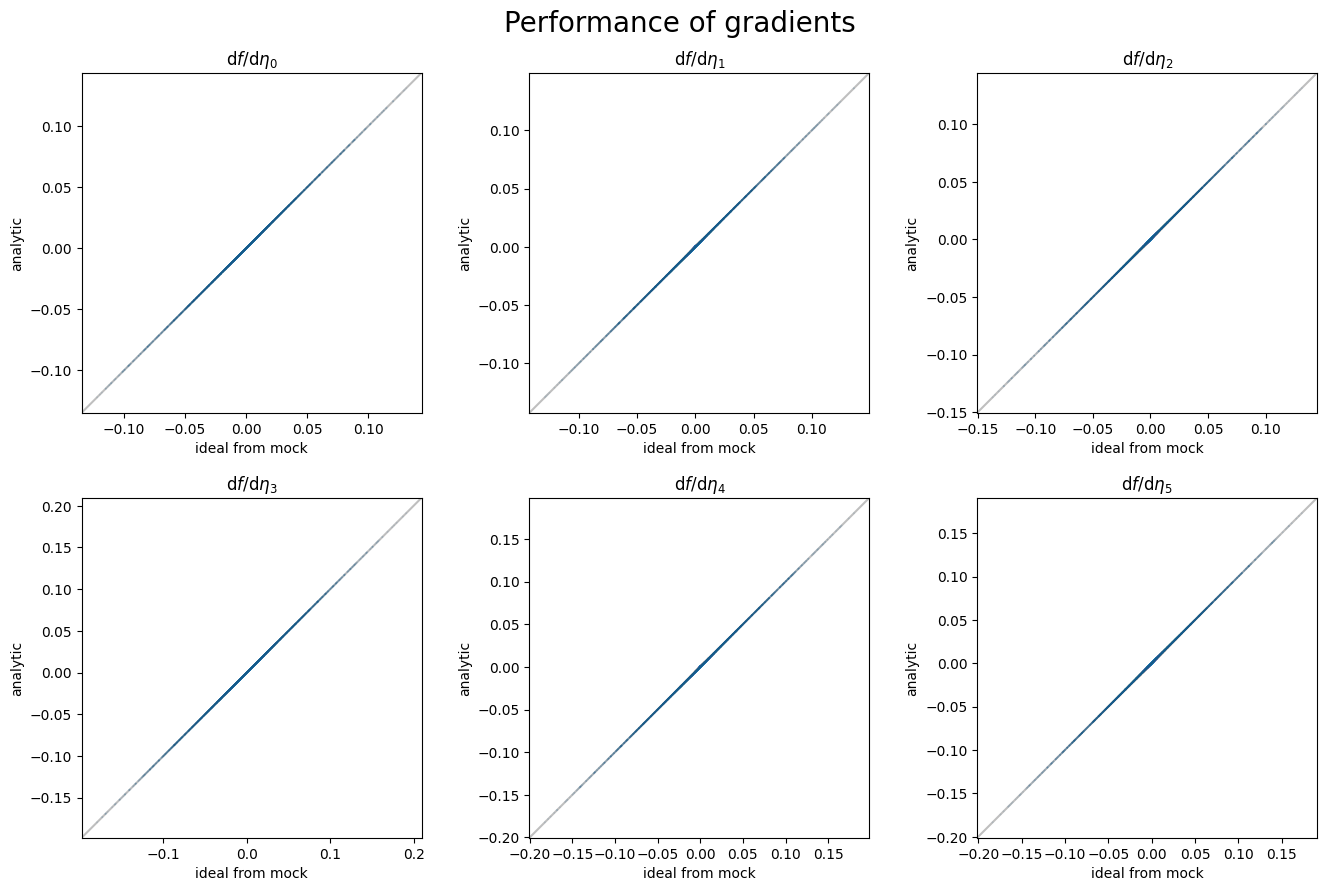

In [130]:
#Plots NF gradients vs idealized gradients
runcell = True
if runcell == True:
    fig,ax_arr = plt.subplots(2,3, figsize=(16,9))

    #Plots the computed values for the derivatives against true values
    for i,ax in enumerate(ax_arr.flat):
        ax.set_aspect('equal')
        if i < 3:
            ax.scatter(
                #
                df_dx[:,i].detach(),
                dx[i],
                alpha=0.1, s=2,
                edgecolors='none'
            )
        else:
            ax.scatter(
                df_dv[:,i-3].detach(),
                dv[i-3],
                alpha=0.1, s=2,
                edgecolors='none'
            )

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xlim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
        ax.set_xlim(xlim)
        ax.set_ylim(xlim)

        ax.plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], c='k', alpha=0.25)

        ax.set_xlabel(r'ideal from mock')
        ax.set_ylabel(r'analytic')

        ax.set_title(rf'$\mathrm{{d}}f / \mathrm{{d}}\eta_{i}$')

    fig.subplots_adjust(
        hspace=0.25, wspace=0.3,
        top=0.91, bottom=0.06
    )
    fig.suptitle('Performance of gradients', fontsize=20)

    fig.savefig('flow_gradients_comparison.png', dpi=100)

### Estimate Mass Density, Enclosed Mass, and Potential

In [262]:
rho, r_center = rho_est(q)
Menc = []
for i in range(0,len(r_center)):
    Menc += [4* np.pi * np.trapz((r_center[0:i]**2)*rho[0:i],r_center[0:i])]

(-25.0, 25.0)

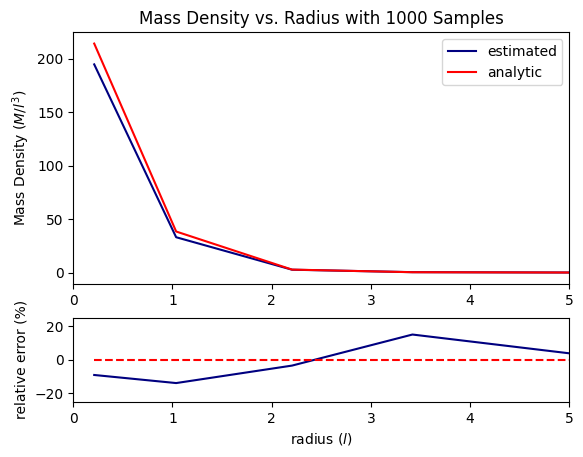

In [263]:
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]})
xmax = 5

axs[0].plot(r_center,rho, label ='estimated', color = 'navy')
axs[0].plot(r_center,rholytic(n_samples,b,r_center), label = 'analytic',  color = 'r')

axs[0].set_ylabel('Mass Density $(M/l^3)$')
axs[0].set_title('Mass Density vs. Radius with ' + str(n_samples) + ' Samples')
axs[0].set_xlim(0,xmax)
axs[0].legend()

axs[1].plot(r_center,(100*(rho-rholytic(n_samples,b,r_center))/rholytic(n_samples,b,r_center)), color = 'navy')
axs[1].plot(r_center,np.zeros_like(r_center), linestyle = '--', color = 'r')
axs[1].set_ylabel('relative error (%)')
axs[1].set_xlabel('radius $(l)$')
axs[1].set_xlim(0,xmax)
axs[1].set_ylim(-25,25)

(-100.0, 10.0)

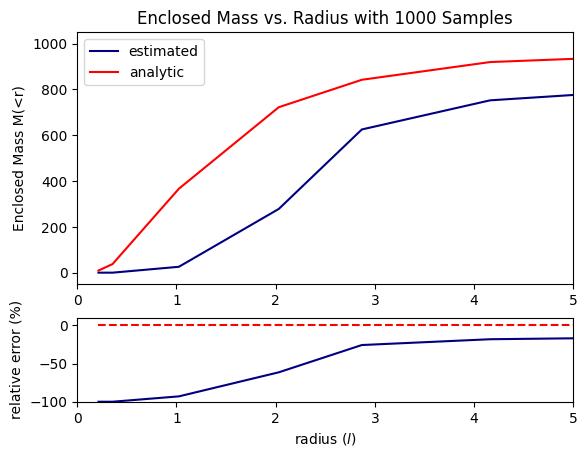

In [260]:
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]})
xmax = 5

axs[0].plot(r_center,Menc, label ='estimated', color = 'navy')
axs[0].plot(r_center,Mlytic(n_samples,b,r_center), label = 'analytic',  color = 'r')

axs[0].set_ylabel('Enclosed Mass M(<r)')
axs[0].set_title('Enclosed Mass vs. Radius with ' + str(n_samples) + ' Samples')
axs[0].set_xlim(0,xmax)
axs[0].legend()

axs[1].plot(r_center,(100*(Menc-Mlytic(n_samples,b,r_center))/Mlytic(n_samples,b,r_center)), color = 'navy')
axs[1].plot(r_center,np.zeros_like(r_center), linestyle = '--', color = 'r')
axs[1].set_ylabel('relative error (%)')
axs[1].set_xlabel('radius $(l)$')
axs[1].set_xlim(0,xmax)
axs[1].set_ylim(-100,10)

### Calculate Potential

In [194]:
Pot = []
    for i in range(0,len(r_center)):
    

1
